<a href="https://colab.research.google.com/github/Henkin2th/AIPI-590.05-Assignement/blob/main/AIPI590_05_adversarial_patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Adversarial Patch Creation and Application**

In this notebook, we will create an adversarial patch designed to fool a pre-trained ResNet34 model. Specifically, we will apply the patch to an image of a frog and attempt to make the model classify it as a lemon (class index 951 in ImageNet).

---

## **1. Import Libraries**

WStart by importing necessary libraries such as torch, torchvision, requests, matplotlib, etc. In Colab, you typically do not need to install torch or torchvision as they come pre-installed, but you will need requests to fetch the image from GitHub.

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

## **2. Load the ResNet34 Model**

We will use a pre-trained ResNet34 model from the torchvision library, which has been trained on ImageNet data. The model will be used to evaluate the effect of our adversarial patch.



In [2]:
# Load the ResNet34 model pre-trained on ImageNet
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model.eval()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 74.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## **3. Image Preprocessing**
We define a preprocessing function that resizes the image to 256x256 pixels, crops it to 224x224 pixels (the input size expected by ResNet34), and normalizes it using the mean and standard deviation values used in ImageNet training.

In [3]:
# Define the transformation to resize and normalize the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

##**4. Load and Preprocess the Frog Image**
In this section, we use the requests library to download the image directly from your GitHub repository. Replace the GitHub image URL with the one that contains the raw link to your image.



In [4]:
# Download an image from a GitHub raw URL and preprocess it
def load_image_from_github(github_url):
    response = requests.get(github_url)
    img = Image.open(BytesIO(response.content))
    img_tensor = preprocess(img)
    return img_tensor

# Replace the URL with your GitHub image's raw URL
github_image_url = 'https://raw.githubusercontent.com/Henkin2th/AIPI-590.05-Assignement/main/Adversarial%20Patches/frog.jpg'
image = load_image_from_github(github_image_url)

## **5. Create the Adversarial Patch**
Now, we define a function to generate the adversarial patch. The patch will be created using gradient ascent to maximize the model's prediction toward a target class (in this case, we are using "lemon" as the target class, class index 951).

In [5]:
# Create an adversarial patch with modified learning rate, iteration count, patch location and size
def create_patch_modified(image, model, target_class, patch_size=(100, 100), lr=0.2, iterations=1000, patch_location=(60, 60)):
    patch = torch.rand((3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.Adam([patch], lr=lr)

    for i in range(iterations):
        optimizer.zero_grad()

        # Paste patch onto the image
        perturbed_image = image.clone()
        perturbed_image[:, patch_location[0]:patch_location[0] + patch_size[0], patch_location[1]:patch_location[1] + patch_size[1]] = patch

        # Pass the perturbed image through the model
        output = model(perturbed_image.unsqueeze(0))

        # Calculate loss as the negative log probability of the target class (lemon)
        loss = -F.log_softmax(output, dim=1)[0, target_class]

        # Backpropagate
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f'Iteration {i}, Loss: {loss.item()}')

    return patch.detach()

# Specify the target class (e.g., lemon, index 951)
target_class = 951

# Create the adversarial patch
modified_patch = create_patch_modified(image, model, target_class)

Iteration 0, Loss: 9.999244689941406
Iteration 100, Loss: 0.0012306743301451206
Iteration 200, Loss: 0.0005710878176614642
Iteration 300, Loss: 0.00035613393993116915
Iteration 400, Loss: 0.00024828212917782366
Iteration 500, Loss: 0.00018594920402392745
Iteration 600, Loss: 0.00014697425649501383
Iteration 700, Loss: 0.0001212284987559542
Iteration 800, Loss: 0.00010275312524754554
Iteration 900, Loss: 8.844937838148326e-05
Iteration 1000, Loss: 7.688703772146255e-05
Iteration 1100, Loss: 6.747018051100895e-05
Iteration 1200, Loss: 6.007967749610543e-05
Iteration 1300, Loss: 5.376194530981593e-05
Iteration 1400, Loss: 4.8397800128441304e-05


##**6. Apply the Patch to the Image**
Once the adversarial patch is created, we apply it to the original image. The patch is placed at a specified location on the image.

In [6]:
# Apply the patch to the image
def apply_patch(image, patch, patch_size=(100, 100), patch_location=(60, 60)):
    perturbed_image = image.clone()
    perturbed_image[:, patch_location[0]:patch_location[0] + patch_size[0], patch_location[1]:patch_location[1] + patch_size[1]] = patch
    return perturbed_image

##**7. Disguise the Patch as a Sticker**
We disguise the patch by applying a circular mask, creating a "sticker" effect. This ensures that the patch blends into the image rather than appearing as a harsh rectangular block.

In [7]:
# Disguise the patch as a circular "sticker"
def disguise_as_sticker(patch, patch_size=(100, 100), shape='circle'):
    if shape == 'circle':
        mask = torch.ones_like(patch)
        center = (patch.size(1) // 2, patch.size(2) // 2)
        radius = patch.size(1) // 2

        # Create a circular mask
        for i in range(patch.size(1)):
            for j in range(patch.size(2)):
                if (i - center[0]) ** 2 + (j - center[1]) ** 2 > radius ** 2:
                    mask[:, i, j] = 0

        # Apply the mask to the patch to create the circular sticker
        patch *= mask

    return patch

# Disguise the patch as a sticker
sticker_patch = disguise_as_sticker(modified_patch)

##**8. Test the Adversarial Patch**
After creating and applying the patch, we test the patched image by passing it through the ResNet34 model and checking the predicted class.

In [8]:
# Test the adversarial patch
def test_adversarial_patch(model, image, patch, patch_size=(100, 100), patch_location=(60, 60)):
    perturbed_image = apply_patch(image, patch, patch_size, patch_location)
    output = model(perturbed_image.unsqueeze(0))
    predicted_class = output.argmax(dim=1).item()
    print(f"Predicted class after applying patch: {predicted_class}")
    return perturbed_image

# Apply the patch and test the model's output
perturbed_image_modified = test_adversarial_patch(model, image, sticker_patch)

Predicted class after applying patch: 951


##**9. Visualize the Patch and Perturbed Image**
We visualize the adversarial patch and the resulting perturbed image.

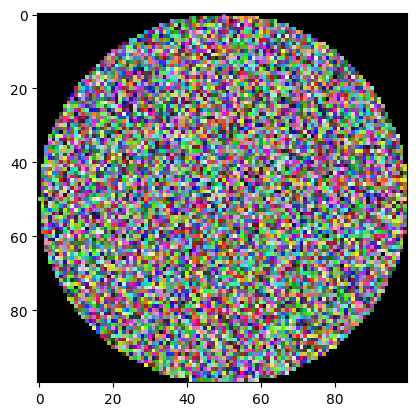

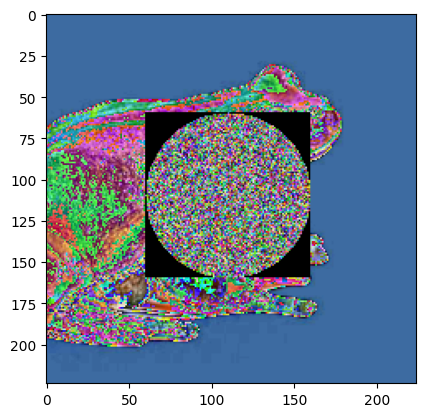

In [9]:
# Visualize the patch and perturbed image
def show_image(tensor):
    unloader = transforms.ToPILImage()
    img = tensor.clone()
    img = unloader(img)
    plt.imshow(img)
    plt.show()

# Visualize the adversarial patch and perturbed image
show_image(sticker_patch)
show_image(perturbed_image_modified)

##**Conclusion**
This notebook demonstrates how to create and apply an adversarial patch designed to fool a ResNet34 model. The patch is disguised as a sticker and placed on an image of a frog, causing the model to misclassify the image as a lemon.